# Real Estate Sale Condition Classification

Based on the data provided in the Kaggle on-going competition "House Prices - Advanced Regression Techniques", the models below predict whether the conditon of sale of a home is normal or not normal.  Logistical, random forest and neural network classifiers were compared.  Because instances of the minority class (homes having non-normal sale conditions) was significantly less than instances of the majority class in this data set, oversampling and undersampling were used to create models where both minority and majority classification are as predictive as possible.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv')
print(df.columns)

pd.set_option('mode.chained_assignment', None)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

### Preprocessing The Data

Machine learning models requires quantitative inputs, however the original data set contains categorical and ordinal data in addition to numeric data.  Below, categorical and ordinal features are converted to usable input data.

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import scale

func_dict = {
    'Typ':7,
    'Min1':6,
    'Min2':5,
    'Mod':4,
    'Maj1':3,
    'Maj2':2,
    'Sev':1,
    'Sal':0  
}

df['FuncScore'] = df['Functional'].map(lambda x: func_dict[x])

quality_dict = {
    'Ex':5,
    'Gd':4,
    'TA':3,
    'Fa':2,
    'Po':1, 
    'No':0
}


# Features ending in 'Score' have been converted from strings to ordered integers
df['KitchenQualScore'] = df['KitchenQual'].map(lambda x: quality_dict[x])

df.loc[df['BsmtQual'].isnull(),'BsmtQual'] = "No"
df['BsmtQualScore'] = df['BsmtQual'].map(lambda x: quality_dict[x])
df.loc[df['BsmtCond'].isnull(),'BsmtCond'] = "No"
df['BsmtCondScore'] = df['BsmtCond'].map(lambda x: quality_dict[x])
df.loc[df['ExterQual'].isnull(),'ExterQual'] = "No"
df['ExterQualScore'] = df['ExterQual'].map(lambda x: quality_dict[x])
df.loc[df['ExterCond'].isnull(),'ExterCond'] = "No"
df['ExterCondScore'] = df['ExterCond'].map(lambda x: quality_dict[x])

# Features with yes/ no categories were changed to 1 and 0 respectively
df['CentralAirScore'] = df['CentralAir'].map(lambda x: 1 if x.title().strip() == 'Y' else 0)

In [3]:
features_of_interest = [
    '1stFlrSF',
    '2ndFlrSF',
    'TotalBsmtSF',
    'OverallQual',
    'OverallCond',
    'FuncScore',
    'TotRmsAbvGrd',
    'BedroomAbvGr',
    'LotArea',
    'GarageArea',
    'KitchenQualScore',
    'BsmtQualScore',
    'BsmtCondScore',
    'CentralAirScore',
    'FullBath',
    'BsmtFullBath',
    'BsmtHalfBath',
    'HalfBath',
    'ExterQualScore',
    'ExterCondScore',
    'SalePrice',
    
    'RoofStyle', 
    'RoofMatl', 
    'Exterior1st', 
    'Exterior2nd', 
    'MasVnrType', 
    'Foundation', 
    'GarageType',
    'MiscFeature',
    'SaleType',
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LandContour',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle'
]

df_foi = df[features_of_interest]

In [4]:
# making sure there are no holes in our data
for feature in features_of_interest:
    print(f"Number of null values for {feature}:", df_foi.loc[df_foi[feature].isnull(), feature].count())
    

Number of null values for 1stFlrSF: 0
Number of null values for 2ndFlrSF: 0
Number of null values for TotalBsmtSF: 0
Number of null values for OverallQual: 0
Number of null values for OverallCond: 0
Number of null values for FuncScore: 0
Number of null values for TotRmsAbvGrd: 0
Number of null values for BedroomAbvGr: 0
Number of null values for LotArea: 0
Number of null values for GarageArea: 0
Number of null values for KitchenQualScore: 0
Number of null values for BsmtQualScore: 0
Number of null values for BsmtCondScore: 0
Number of null values for CentralAirScore: 0
Number of null values for FullBath: 0
Number of null values for BsmtFullBath: 0
Number of null values for BsmtHalfBath: 0
Number of null values for HalfBath: 0
Number of null values for ExterQualScore: 0
Number of null values for ExterCondScore: 0
Number of null values for SalePrice: 0
Number of null values for RoofStyle: 0
Number of null values for RoofMatl: 0
Number of null values for Exterior1st: 0
Number of null valu

In [5]:
# using get_dummies, categorical data is transformed into numeric data usable for machine learning

category_features_to_dummies = [
    'RoofStyle', 
    'RoofMatl', 
    'Exterior1st', 
    'Exterior2nd', 
    'MasVnrType', 
    'Foundation', 
    'GarageType',
    'MiscFeature',
    'SaleType',
    'MSSubClass',
    'MSZoning',
    'Street',
    'Alley',
    'LandContour',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle'
]

for feature in category_features_to_dummies:
    temp_df = pd.get_dummies(df_foi[feature], prefix=feature, prefix_sep='_')
    df_foi = df_foi.join(temp_df)
    df_foi.drop(columns=feature, inplace=True)
    

In [6]:
# data is standardized using z-scores to prevent features with more variation 
# having undue weight in the classification model

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

continuous_features = [
    '1stFlrSF',
    '2ndFlrSF',
    'TotalBsmtSF',
    'OverallQual',
    'OverallCond',
    'FuncScore',
    'TotRmsAbvGrd',
    'BedroomAbvGr',
    'LotArea',
    'GarageArea',
    'KitchenQualScore',
    'BsmtQualScore',
    'BsmtCondScore',
    'CentralAirScore',
    'FullBath',
    'BsmtFullBath',
    'BsmtHalfBath',
    'HalfBath',
    'ExterQualScore',
    'ExterCondScore',
    'SalePrice'
]

scaler = preprocessing.StandardScaler()
for feature in continuous_features:
    df_foi[feature] = scaler.fit_transform(df_foi[feature].values.reshape(-1,1))
    

In [7]:
# Sale condition is transformed into zeroes for normal/ majority class
# and ones for non-normal/ minority class

def prepare_y(df):
    df.loc[df['SaleCondition'] == 'Normal', 'SaleCondition'] = 0
    df.loc[df['SaleCondition'] != 0, 'SaleCondition'] = 1
    return df['SaleCondition']

In [8]:
# initial_ratio of minority to majority class

count = df['SaleCondition'].value_counts()
i_r = count[1]/count[0] 
i_r

0.10434056761268781

In [9]:
X = df_foi
y = prepare_y(df)
y = y.astype('int')


### Logistic Regression Models

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

model_lr = LogisticRegression(max_iter=240)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

print('Logistical Regression - Imbalanced Precision: %.3f' % precision_score(y_test, y_pred))
print('Logistical Regression - Imbalanced Recall: %.3f' % recall_score(y_test, y_pred))
print('Logistical Regression - Imbalanced Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Logistical Regression - Imbalanced F1 Score: %.3f' % f1_score(y_test, y_pred))

# model_scores will be updated for every model
model_scores = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score'])

model_scores.loc[len(model_scores.index)] = [
    'Logistical Regression - Imbalanced', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]


Logistical Regression - Imbalanced Precision: 0.805
Logistical Regression - Imbalanced Recall: 0.524
Logistical Regression - Imbalanced Accuracy: 0.870
Logistical Regression - Imbalanced F1 Score: 0.635


In [11]:
from imblearn import under_sampling, over_sampling
from imblearn.under_sampling import RandomUnderSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

model_lr_u = LogisticRegression(max_iter=240)
model_lr_u.fit(X_train_rus, y_train_rus)
y_pred = model_lr_u.predict(X_test)

print('Logistical Regression - Undersampling Precision: %.3f' % precision_score(y_test, y_pred))
print('Logistical Regression - Undersampling Recall: %.3f' % recall_score(y_test, y_pred))
print('Logistical Regression - Undersampling Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Logistical Regression - Undersampling F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Logistical Regression - Undersampling', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]


Logistical Regression - Undersampling Precision: 0.512
Logistical Regression - Undersampling Recall: 0.683
Logistical Regression - Undersampling Accuracy: 0.791
Logistical Regression - Undersampling F1 Score: 0.585


In [12]:
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

model_lr_o = LogisticRegression(max_iter=240)
model_lr_o.fit(X_train_ros, y_train_ros)
y_pred = model_lr_o.predict(X_test)

print('Logistical Regression - Oversampling Precision: %.3f' % precision_score(y_test, y_pred))
print('Logistical Regression - Oversampling Recall: %.3f' % recall_score(y_test, y_pred))
print('Logistical Regression - Oversampling Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Logistical Regression - Oversampling F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Logistical Regression - Oversampling', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]


Logistical Regression - Oversampling Precision: 0.580
Logistical Regression - Oversampling Recall: 0.635
Logistical Regression - Oversampling Accuracy: 0.822
Logistical Regression - Oversampling F1 Score: 0.606


### Hyperparameters Tuning

To find the optimal minority to majority class ratio when under- and oversampling, with respect to both accuracy and F1-score, the models were ran repeatedly.  These scores were compared and the ratio yeilding the best scores is output.  This same technique is used for other models and other hyperparameters.  These blocks of code are commented out due to their longer runtimes.

In [13]:
# best_accuracy_score = 0
# best_f1_score = 0
# best_min_samp_ratio = 0

# for x in range(0,500):
#     if ((1+x/100)*i_r) <= 1:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#         rus_weighted = RandomUnderSampler(random_state=0, sampling_strategy=(1+x/100)*i_r)
#         X_train_rus, y_train_rus = rus_weighted.fit_resample(X_train, y_train)

#         model_lr_u = LogisticRegression(max_iter=500)
#         model_lr_u.fit(X_train_rus, y_train_rus)
#         y_pred = model_lr_u.predict(X_test)

#         current_accuracy_score = accuracy_score(y_test, y_pred)
#         current_f1_score = f1_score(y_test, y_pred)
#         current_min_samp_ratio = (1+x/100)*i_r

#         if (current_accuracy_score*current_f1_score > best_accuracy_score*best_f1_score):
#             best_accuracy_score = current_accuracy_score
#             best_f1_score = current_f1_score
#             best_min_samp_ratio = current_min_samp_ratio
        
# print('When undersampling, the optimum minority class ratio: %.2f' % best_min_samp_ratio)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rus_weighted = RandomUnderSampler(random_state=0, sampling_strategy=0.47)
X_train_rus, y_train_rus = rus_weighted.fit_resample(X_train, y_train)

model_lr_u = LogisticRegression(max_iter=500)
model_lr_u.fit(X_train_rus, y_train_rus)
y_pred = model_lr_u.predict(X_test)

print('Logistical Regression - Undersampling, weighted Precision: %.3f' % precision_score(y_test, y_pred))
print('Logistical Regression - Undersampling, weighted Recall: %.3f' % recall_score(y_test, y_pred))
print('Logistical Regression - Undersampling, weighted Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Logistical Regression - Undersampling, weighted F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Logistical Regression - Undersampling, weighted', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Logistical Regression - Undersampling, weighted Precision: 0.717
Logistical Regression - Undersampling, weighted Recall: 0.603
Logistical Regression - Undersampling, weighted Accuracy: 0.863
Logistical Regression - Undersampling, weighted F1 Score: 0.655


In [15]:
# best_accuracy_score = 0
# best_f1_score = 0
# best_min_samp_ratio = 0

# for x in range(0,500):
#     if ((1+x/100)*i_r) <= 1:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#         ros_weighted = RandomOverSampler(random_state=0, sampling_strategy=(1+x/100)*i_r)
#         X_train_ros, y_train_ros = ros_weighted.fit_resample(X_train, y_train)

#         model_lr_o = LogisticRegression(max_iter=500)
#         model_lr_o.fit(X_train_ros, y_train_ros)
#         y_pred = model_lr_o.predict(X_test)

#         current_accuracy_score = accuracy_score(y_test, y_pred)
#         current_f1_score = f1_score(y_test, y_pred)
#         current_min_samp_ratio = (1+x/100)*i_r

#         if (current_accuracy_score*current_f1_score > best_accuracy_score*best_f1_score):
#             best_accuracy_score = current_accuracy_score
#             best_f1_score = current_f1_score
#             best_min_samp_ratio = current_min_samp_ratio
        
# print('When oversampling, the optimum minority class ratio: %.2f' % best_min_samp_ratio)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ros_weighted = RandomOverSampler(random_state=0, sampling_strategy=.32)
X_train_ros, y_train_ros = ros_weighted.fit_resample(X_train, y_train)

model_lr_o = LogisticRegression(max_iter=500)
model_lr_o.fit(X_train_ros, y_train_ros)
y_pred = model_lr_o.predict(X_test)

print('Logistical Regression - Oversampling, weighted Precision: %.3f' % precision_score(y_test, y_pred))
print('Logistical Regression - Oversampling, weighted Recall: %.3f' % recall_score(y_test, y_pred))
print('Logistical Regression - Oversampling, weighted Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Logistical Regression - Oversampling, weighted F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Logistical Regression - Oversampling, weighted', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Logistical Regression - Oversampling, weighted Precision: 0.761
Logistical Regression - Oversampling, weighted Recall: 0.556
Logistical Regression - Oversampling, weighted Accuracy: 0.866
Logistical Regression - Oversampling, weighted F1 Score: 0.642


In [17]:
# from sklearn.ensemble import RandomForestClassifier

# best_accuracy_score = 0
# best_f1_score = 0
# best_n_estimator = 0

# for x in range(1,100):

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     rfc = RandomForestClassifier(n_estimators=x, random_state=0)
#     rfc.fit(X_train, y_train)
#     y_pred = rfc.predict(X_test)
    
#     current_accuracy_score = accuracy_score(y_test, y_pred)
#     current_f1_score = f1_score(y_test, y_pred)

#     if (current_accuracy_score*current_f1_score > best_accuracy_score*best_f1_score):
#         best_accuracy_score = current_accuracy_score
#         best_f1_score = current_f1_score
#         best_n_estimator = x
        
# print('When imbalanced, the optimum number of estimators is', best_n_estimator)

In [18]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rfc = RandomForestClassifier(n_estimators=10, random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Random Forest Classifier - Imbalanced Precision: %.3f' % precision_score(y_test, y_pred))
print('Random Forest Classifier - Imbalanced Recall: %.3f' % recall_score(y_test, y_pred))
print('Random Forest Classifier - Imbalanced Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Random Forest Classifier - Imbalanced F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Random Forest Classifier - Imbalanced', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Random Forest Classifier - Imbalanced Precision: 0.967
Random Forest Classifier - Imbalanced Recall: 0.460
Random Forest Classifier - Imbalanced Accuracy: 0.880
Random Forest Classifier - Imbalanced F1 Score: 0.624


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

rfc_u = RandomForestClassifier(n_estimators=10, random_state=0)
rfc_u.fit(X_train_rus, y_train_rus)
y_pred = rfc_u.predict(X_test)

print('Random Forest Classifier - Undersampling Precision: %.3f' % precision_score(y_test, y_pred))
print('Random Forest Classifier - Undersampling Recall: %.3f' % recall_score(y_test, y_pred))
print('Random Forest Classifier - Undersampling Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Random Forest Classifier - Undersampling F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Random Forest Classifier - Undersampling', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Random Forest Classifier - Undersampling Precision: 0.528
Random Forest Classifier - Undersampling Recall: 0.603
Random Forest Classifier - Undersampling Accuracy: 0.798
Random Forest Classifier - Undersampling F1 Score: 0.563


In [20]:
# best_accuracy_score = 0
# best_f1_score = 0
# best_min_samp_ratio = 0

# for x in range(100,550):
#     if ((x/100)*i_r) <= 1:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#         rus_weighted = RandomUnderSampler(random_state=0, sampling_strategy=(x/100)*i_r)
#         X_train_rus, y_train_rus = rus_weighted.fit_resample(X_train, y_train)

#         rfc_u = RandomForestClassifier(n_estimators=10, random_state=0)
#         rfc_u.fit(X_train_rus, y_train_rus)
#         y_pred = rfc_u.predict(X_test)

#         current_accuracy_score = accuracy_score(y_test, y_pred)
#         current_f1_score = f1_score(y_test, y_pred)
#         current_min_samp_ratio = (x/100)*i_r

#         if (current_accuracy_score*current_f1_score > best_accuracy_score*best_f1_score):
#             best_accuracy_score = current_accuracy_score
#             best_f1_score = current_f1_score
#             best_min_samp_ratio = current_min_samp_ratio

# print('When undersampling, the optimum minority class ratio: %.2f' % best_min_samp_ratio)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rus = RandomUnderSampler(random_state=0, sampling_strategy=0.44)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

rfc_u = RandomForestClassifier(n_estimators=10, random_state=0)
rfc_u.fit(X_train_rus, y_train_rus)
y_pred = rfc_u.predict(X_test)

print('Random Forest Classifier - Undersampling, weighted Precision: %.3f' % precision_score(y_test, y_pred))
print('Random Forest Classifier - Undersampling, weighted Recall: %.3f' % recall_score(y_test, y_pred))
print('Random Forest Classifier - Undersampling, weighted Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Random Forest Classifier - Undersampling, weighted F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Random Forest Classifier - Undersampling, weighted', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Random Forest Classifier - Undersampling, weighted Precision: 0.821
Random Forest Classifier - Undersampling, weighted Recall: 0.508
Random Forest Classifier - Undersampling, weighted Accuracy: 0.870
Random Forest Classifier - Undersampling, weighted F1 Score: 0.627


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

rfc_o = RandomForestClassifier(n_estimators=10, random_state=0)
rfc_o.fit(X_train_ros, y_train_ros)
y_pred = rfc_o.predict(X_test)

print('Random Forest Classifier - Oversampling Precision: %.3f' % precision_score(y_test, y_pred))
print('Random Forest Classifier - Oversampling Recall: %.3f' % recall_score(y_test, y_pred))
print('Random Forest Classifier - Oversampling Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Random Forest Classifier - Oversampling F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Random Forest Classifier - Oversampling', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Random Forest Classifier - Oversampling Precision: 1.000
Random Forest Classifier - Oversampling Recall: 0.492
Random Forest Classifier - Oversampling Accuracy: 0.890
Random Forest Classifier - Oversampling F1 Score: 0.660


In [23]:
# best_accuracy_score = 0
# best_f1_score = 0
# best_min_samp_ratio = 0

# for x in range(100,550):
#     if ((x/100)*i_r) <= 1:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#         ros_weighted = RandomOverSampler(random_state=0, sampling_strategy=(x/100)*i_r)
#         X_train_ros, y_train_ros = ros_weighted.fit_resample(X_train, y_train)

#         rfc_o = RandomForestClassifier(n_estimators=10, random_state=0)
#         rfc_o.fit(X_train_ros, y_train_ros)
#         y_pred = rfc_o.predict(X_test)

#         current_accuracy_score = accuracy_score(y_test, y_pred)
#         current_f1_score = f1_score(y_test, y_pred)
#         current_min_samp_ratio = (x/100)*i_r

#         if (current_accuracy_score*current_f1_score > best_accuracy_score*best_f1_score):
#             best_accuracy_score = current_accuracy_score
#             best_f1_score = current_f1_score
#             best_min_samp_ratio = current_min_samp_ratio
        
# print('When oversampling, the optimum minority class ratio: %.2f' % best_min_samp_ratio)


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ros_weighted = RandomOverSampler(random_state=0, sampling_strategy=0.82)
X_train_ros, y_train_ros = ros_weighted.fit_resample(X_train, y_train)

rfc_o = RandomForestClassifier(n_estimators=7, random_state=0)
rfc_o.fit(X_train_ros, y_train_ros)
y_pred = rfc_o.predict(X_test)

print('Random Forest Classifier - Oversampling, weighted Precision: %.3f' % precision_score(y_test, y_pred))
print('Random Forest Classifier - Oversampling, weighted Recall: %.3f' % recall_score(y_test, y_pred))
print('Random Forest Classifier - Oversampling, weighted Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Random Forest Classifier - Oversampling, weighted F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Random Forest Classifier - Oversampling, weighted', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Random Forest Classifier - Oversampling, weighted Precision: 0.825
Random Forest Classifier - Oversampling, weighted Recall: 0.524
Random Forest Classifier - Oversampling, weighted Accuracy: 0.873
Random Forest Classifier - Oversampling, weighted F1 Score: 0.641


In [25]:
# from sklearn.neural_network import MLPClassifier

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# hid_lay_sizes = []
# for x in range(1, 11):
#     for y in range(1, 11):
#         hid_lay_sizes.append((x,y))
        
# best_accuracy_score = 0
# best_f1_score = 0
# best_hidden_layer_dim = ''


# for dim in hid_lay_sizes:
#     nn = MLPClassifier(max_iter=1100, alpha=0.01, activation="relu", hidden_layer_sizes=dim)
#     nn.fit(X_train_ros, y_train_ros)
#     y_pred = nn.predict(X_test)

#     current_accuracy_score = accuracy_score(y_test, y_pred)
#     current_f1_score = f1_score(y_test, y_pred)
#     current_hidden_layer_dim = dim

#     if (current_accuracy_score*current_f1_score > best_accuracy_score*best_f1_score):
#         best_accuracy_score = current_accuracy_score
#         best_f1_score = current_f1_score
#         best_hidden_layer_dim = current_hidden_layer_dim
        
#     print('Finished ', str(dim), 'with accuracy of', current_accuracy_score, 'and f1 score of')
    
# print('Best hidden layer dimensions: ', best_hidden_layer_dim)

In [26]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

nn = MLPClassifier(max_iter=1100, activation="relu", hidden_layer_sizes=(7,4))
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)

print('Neural Network (MLPClassifier) - Imbalanced Precision: %.3f' % precision_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Imbalanced Recall: %.3f' % recall_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Imbalanced Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Imbalanced F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Neural Network (MLPClassifier) - Imbalanced', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Neural Network (MLPClassifier) - Imbalanced Precision: 0.705
Neural Network (MLPClassifier) - Imbalanced Recall: 0.608
Neural Network (MLPClassifier) - Imbalanced Accuracy: 0.887
Neural Network (MLPClassifier) - Imbalanced F1 Score: 0.653


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

nn = MLPClassifier(max_iter=1100, activation="relu", alpha=0.01, hidden_layer_sizes=(7,4))
nn.fit(X_train_rus, y_train_rus)
y_pred = nn.predict(X_test)

print('Neural Network (MLPClassifier) - Undersampling Precision: %.3f' % precision_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Undersampling Recall: %.3f' % recall_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Undersampling Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Undersampling F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Neural Network (MLPClassifier) - Undersampling', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Neural Network (MLPClassifier) - Undersampling Precision: 0.439
Neural Network (MLPClassifier) - Undersampling Recall: 0.746
Neural Network (MLPClassifier) - Undersampling Accuracy: 0.740
Neural Network (MLPClassifier) - Undersampling F1 Score: 0.553


In [28]:
# best_accuracy_score = 0
# best_f1_score = 0
# best_min_samp_ratio = 0

# for x in range(20,55):
#     if ((x/10)*i_r) <= 1:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#         rus_weighted = RandomUnderSampler(random_state=0, sampling_strategy=(x/10)*i_r)
#         X_train_rus, y_train_rus = rus_weighted.fit_resample(X_train, y_train)

#         nn_u = MLPClassifier(max_iter=1100, alpha=0.01, activation="relu", hidden_layer_sizes=(7,4))
#         nn_u.fit(X_train_rus, y_train_rus)
#         y_pred = nn_u.predict(X_test)

#         current_accuracy_score = accuracy_score(y_test, y_pred)
#         current_f1_score = f1_score(y_test, y_pred)
#         current_min_samp_ratio = (x/10)*i_r

#         if (current_accuracy_score*current_f1_score > best_accuracy_score*best_f1_score):
#             best_accuracy_score = current_accuracy_score
#             best_f1_score = current_f1_score
#             best_min_samp_ratio = current_min_samp_ratio

        
# print('When undersampling, the optimum minority class ratio: %.2f' % best_min_samp_ratio)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rus = RandomUnderSampler(random_state=0, sampling_strategy=0.55)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

nn = MLPClassifier(max_iter=1100, activation="relu", alpha=0.01, hidden_layer_sizes=(7,4))
nn.fit(X_train_rus, y_train_rus)
y_pred = nn.predict(X_test)

print('Neural Network (MLPClassifier) - Undersampling, weighted Precision: %.3f' % precision_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Undersampling, weighted Recall: %.3f' % recall_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Undersampling, weighted Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Undersampling, weighted F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Neural Network (MLPClassifier) - Undersampling, weighted', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Neural Network (MLPClassifier) - Undersampling, weighted Precision: 0.476
Neural Network (MLPClassifier) - Undersampling, weighted Recall: 0.635
Neural Network (MLPClassifier) - Undersampling, weighted Accuracy: 0.771
Neural Network (MLPClassifier) - Undersampling, weighted F1 Score: 0.544


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

nn = MLPClassifier(max_iter=1100, activation="relu", alpha=0.01, hidden_layer_sizes=(7,1))
nn.fit(X_train_ros, y_train_ros)
y_pred = nn.predict(X_test)

print('Neural Network (MLPClassifier) - Oversampling Precision: %.3f' % precision_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Oversampling Recall: %.3f' % recall_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Oversampling Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Oversampling F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Neural Network (MLPClassifier) - Oversampling', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Neural Network (MLPClassifier) - Oversampling Precision: 0.649
Neural Network (MLPClassifier) - Oversampling Recall: 0.587
Neural Network (MLPClassifier) - Oversampling Accuracy: 0.842
Neural Network (MLPClassifier) - Oversampling F1 Score: 0.617


In [31]:
# best_accuracy_score = 0
# best_f1_score = 0
# best_min_samp_ratio = 0


# for x in range(10,55):
#     if ((x/10)*i_r) <= 1:
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#         ros_weighted = RandomOverSampler(random_state=0, sampling_strategy=(x/10)*i_r)
#         X_train_ros, y_train_ros = ros_weighted.fit_resample(X_train, y_train)

#         nn_o = MLPClassifier(max_iter=1100, alpha=0.01, activation="relu", hidden_layer_sizes=(7,4))
#         nn_o.fit(X_train_ros, y_train_ros)
#         y_pred = nn_o.predict(X_test)

#         current_accuracy_score = accuracy_score(y_test, y_pred)
#         current_f1_score = f1_score(y_test, y_pred)
#         current_min_samp_ratio = (x/10)*i_r

#         if (current_accuracy_score*current_f1_score > best_accuracy_score*best_f1_score):
#             best_accuracy_score = current_accuracy_score
#             best_f1_score = current_f1_score
#             best_min_samp_ratio = current_min_samp_ratio

        
# print('When oversampling, the optimum minority class ratio: %.2f' % best_min_samp_ratio)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

ros_weighted = RandomOverSampler(random_state=0, sampling_strategy=0.83)
X_train_ros, y_train_ros = ros_weighted.fit_resample(X_train, y_train)

nn = MLPClassifier(max_iter=1100, activation="relu", alpha=0.01, hidden_layer_sizes=(7,4))
nn.fit(X_train_ros, y_train_ros)
y_pred = nn.predict(X_test)

print('Neural Network (MLPClassifier) - Oversampling, weighted Precision: %.3f' % precision_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Oversampling, weighted Recall: %.3f' % recall_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Oversampling, weighted Accuracy: %.3f' % accuracy_score(y_test, y_pred))
print('Neural Network (MLPClassifier) - Oversampling, weighted F1 Score: %.3f' % f1_score(y_test, y_pred))

model_scores.loc[len(model_scores.index)] = [
    'Neural Network (MLPClassifier) - Oversampling, weighted', 
    round(accuracy_score(y_test, y_pred), 4), 
    round(f1_score(y_test, y_pred), 4)
]

Neural Network (MLPClassifier) - Oversampling, weighted Precision: 0.617
Neural Network (MLPClassifier) - Oversampling, weighted Recall: 0.587
Neural Network (MLPClassifier) - Oversampling, weighted Accuracy: 0.832
Neural Network (MLPClassifier) - Oversampling, weighted F1 Score: 0.602


### Conclusion

The best overall model was the one-hundred percent oversampled rand forest classifier.  The best models did not only have a high accuracy score, but they also had relatively high F1-score suggesting that the model's ability to accurately predict a non-normal home sale condition is more effective.  Oversampling yeilded slightly better results than undersampling in general, and the random forest classifiers performed best overall.


In [33]:
model_scores.sort_values(by=['Accuracy','F1_Score'], ascending=False, inplace=True)
model_scores

,Model,Accuracy,F1_Score
8,Random Forest Classifier - Oversampling,0.8904,0.6596
10,Neural Network (MLPClassifier) - Imbalanced,0.8870,0.6526
5,Random Forest Classifier - Imbalanced,0.8801,0.6237
9,"Random Forest Classifier - Oversampling, weighted",0.8733,0.6408
0,Logistical Regression - Imbalanced,0.8699,0.6346
7,"Random Forest Classifier - Undersampling, weig...",0.8699,0.6275
4,"Logistical Regression - Oversampling, weighted",0.8664,0.6422
3,"Logistical Regression - Undersampling, weighted",0.8630,0.6552
13,Neural Network (MLPClassifier) - Oversampling,0.8425,0.6167
14,"Neural Network (MLPClassifier) - Oversampling,...",0.8322,0.6016


In [34]:
best_models = model_scores.loc[((model_scores['Accuracy']>0.85) & (model_scores['F1_Score']>0.63))]
best_models

,Model,Accuracy,F1_Score
8,Random Forest Classifier - Oversampling,0.8904,0.6596
10,Neural Network (MLPClassifier) - Imbalanced,0.8870,0.6526
9,"Random Forest Classifier - Oversampling, weighted",0.8733,0.6408
0,Logistical Regression - Imbalanced,0.8699,0.6346
4,"Logistical Regression - Oversampling, weighted",0.8664,0.6422
3,"Logistical Regression - Undersampling, weighted",0.8630,0.6552


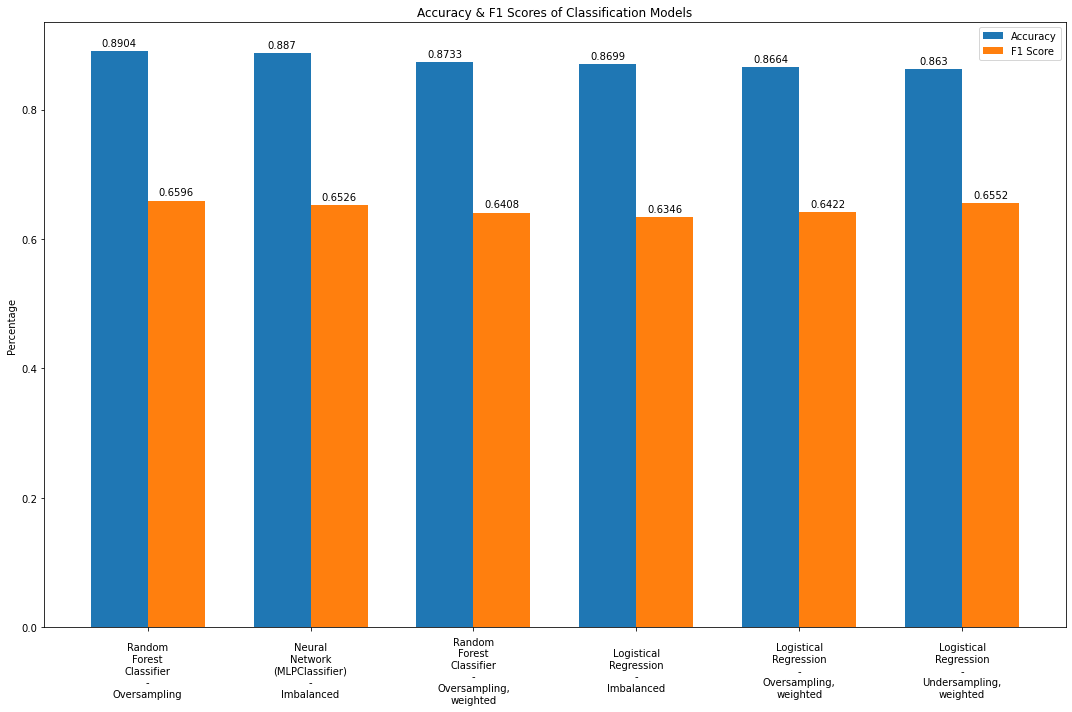

In [35]:
import matplotlib.pyplot as plt


best_models["Model"] = best_models["Model"].map(lambda x: x.replace(' ', '\n'))

model_names = best_models["Model"]
acc_scores = best_models["Accuracy"]
f1_scores = best_models["F1_Score"]


x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
rects1 = ax.bar(x - width/2, acc_scores, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
font = {
    'horizontalalignment':'center',
    'verticalalignment':'center',
    'rotation':'horizontal'
}
ax.set_ylabel('Percentage')
ax.set_title('Accuracy & F1 Scores of Classification Models')
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontdict=font)
ax.tick_params(axis='x', which='major', pad=40)

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)


fig.tight_layout()
